In [58]:
from scipy.special import erf
from scipy.optimize import curve_fit
import numpy as np
import time
import pandas as pd

import benchmark_utils as utils
from util import util

In [59]:
# We import the sample_submission.csv file as a way of determining
# the order of the rows in out output file
sample_submission = pd.read_csv("../sample_submission.csv")

# The fips_key.csv file contains standard information about each county
key = pd.read_csv("../data/us/processing_data/fips_key.csv", encoding='latin-1')

# Daily deaths contains the death count per day for each county.
# Cumulative deaths contains the total death count for each county
# by day.
daily_deaths = pd.read_csv("../data/us/covid/nyt_us_counties_daily.csv")
cumulative_deaths = pd.read_csv("../data/us/covid/deaths.csv")
county_land_areas = pd.read_csv("../data/us/demographics/county_land_areas.csv", encoding='latin1')
county_population = pd.read_csv("../data/us/demographics/county_populations.csv", encoding='latin1')
mobility_data = pd.read_csv("../data/us/mobility/DL-us-m50.csv", encoding='latin1')

# List of all counties
all_fips = key["FIPS"].tolist()

util = util(daily_deaths, cumulative_deaths, county_land_areas, county_population, mobility_data, key)

In [11]:
def erf_curve(t, log_max, slope, center):
    '''
    t: array of time values to input to the erf function
    log_max, slope, center: parameters of the erf curve
    '''
    # Using log(max) as the input rather than just max makes it easier for a curve fitter to match exponential data
    max_val = 10 ** log_max
    deaths = max_val * (1 + erf(slope * (t - center))) / 2
    return deaths


def lin_curve(t, slope, intercept):
    '''
    t: array of time values to input to the linear function
    slope, intercept: parameters of the line
    '''
    ret = t * slope + intercept
    return ret

def get_time_list(data, future=0):
    '''
    data: general dataframe, used to find the first date in history
    future: number of days to extend the time values past present day
    '''
    t = data['date_processed'].values
    t = np.arange(np.min(t), np.max(t) + 1)  # Fill in any potential missing days
    if future > 0:  # Add on days in the future
        extrapolation = np.arange(future)
        t = np.concatenate((t, extrapolation + t[-1] + 1))
    return t

In [29]:
def run_model(func, params, t):
    '''
    func: method handle being run
    params: parameters to feed to the model
    t: input time values to the model
    '''
    preds = func(t, *params)
    preds[preds < 0] = 0  # Remove spurious negative death predictions

    return preds

def make_erf_point_predictions(df, county_fips, key='deaths', last_date_pred='2020-06-30', start_date='2020-03-31',
                               boundary_date=None):
    '''
    df: main nyt data frame
    county_fips: fips code of the county to be fit
    key: 'deaths' for COVID-19 deaths, 'cases' for COVID-19 confirmed cases
    last_date_pred: last day to make predictions for. If 'None', stop at current day
    start_date: first date to list fitted values for. If 'None', start at beginning of dataframe. If do_diff is True,
        this should be one day before the first day you want difference values for
    boundary_date: date at which to cut off data used for fitting
    do_diff: if true, report the daily increase in cases/deaths rather than cumulative values
    '''
    num_days = int(utils.process_date(last_date_pred, df) - utils.process_date(start_date, df))
    data = utils.get_region_data(df, county_fips)
    if len(data) == 0:  # If there's no data for this FIPS, just return zeroes
        return np.zeros(num_days)
    first_date_obv_proc = np.min(data['date_processed'].values)
    boundary = None if boundary_date is None else int(utils.process_date(boundary_date, df) - first_date_obv_proc + 1)

    x = data['date_processed'].values[:boundary]
    if len(x) == 0:  # If there's no data for this FIPS, just return zeroes
        return np.zeros(num_days)
    if start_date is None:
        start_date_proc = first_date_obv_proc
    else:
        start_date_proc = utils.process_date(start_date, df)
    last_date_obv_proc = np.max(x)
    if last_date_pred is None:
        last_date_pred_proc = last_date_obv_proc
    else:
        last_date_pred_proc = utils.process_date(last_date_pred, df)

    y = data[key].values[:boundary]
    if np.max(y) == 0:  # If all data we have for this FIPS is zeroes, just return zeroes
        return np.zeros(num_days)
    thresh_y = y[y >= 10]  # Isolate all days with at least 10 cases/deaths
    # If we have fewer than 5 days with substantial numbers of cases/deaths there isn't enough information to do an
    # erf fit, so just do a simple linear fit instead
    do_lin_model = len(thresh_y) < 5
    if do_lin_model:
        fit_func = lin_curve
        # Perform a linear fit on the latest 5 days of data
        fit_x, fit_y = x[-5:], y[-5:]
        # Pad with zeroes if we have fewer than 5 days of data
        if len(fit_x) < 5:
            fit_x = np.concatenate((np.zeros(5 - len(fit_x)), fit_x))
            fit_y = np.concatenate((np.zeros(5 - len(fit_y)), fit_y))
        fit_params0 = [0, 0]
        # The slope should be at least 0 and at most the largest 1-day increase
        # The intercept can be very low but shouldn't be above the minimum data value
        fit_bounds = [[0, -100 * np.max(y)], [max(1, np.max(np.diff(fit_y))), np.min(y)]]
    else:
        fit_func = erf_curve
        fit_x, fit_y = x, y
        fit_params0 = [np.log10(2 * np.max(data[key])), 0.1, 30]
        # The max value should be between the current max and 100x the current max
        # The slope was given a wide range around common values
        # The infection shouldn't peak before the data started or after the end of ~July
        fit_bounds = [bnd for bnd in zip(*[[np.log10(np.max(data[key])), np.log10(100 * np.max(data[key]))],
                                           [0.001, 10],
                                           [0, 200]])]
    # Use scipy to fit either a linear or erf model to the data
    popt, pcov = curve_fit(fit_func, fit_x, fit_y,
                           p0=fit_params0, bounds=fit_bounds)
    t = np.arange(start_date_proc, last_date_pred_proc + 1)
    return np.diff(run_model(fit_func, popt, t))

In [51]:
def predict_all_counties(df, last_date_pred='2020-05-23', out_file='erf_model_predictions.csv', boundary_date=None,
                         key='deaths'):
    out_dates = utils.all_output_dates()
    out_fips, all_row_starts = utils.all_output_fips('sample_submission.csv')
    num_dates, num_fips = len(out_dates), len(out_fips)

    
    preds_map = {}
    for fi, fips in enumerate(out_fips):
        print('Processing FIPS', fips)
        pred = make_erf_point_predictions(df, fips, last_date_pred=last_date_pred, boundary_date=boundary_date,
                                           start_date=boundary_date, key=key)
        
        preds_map[fips] = pred
        
    return preds_map

In [52]:
df = utils.get_processed_df()
preds_map = predict_all_counties(df, boundary_date='2020-04-18', key='deaths')

Processing FIPS 10001
Processing FIPS 10003
Processing FIPS 10005
Processing FIPS 1001
Processing FIPS 1003
Processing FIPS 1005
Processing FIPS 1007
Processing FIPS 1009
Processing FIPS 1011
Processing FIPS 1013
Processing FIPS 1015
Processing FIPS 1017
Processing FIPS 1019
Processing FIPS 1021
Processing FIPS 1023
Processing FIPS 1025
Processing FIPS 1027
Processing FIPS 1029
Processing FIPS 1031
Processing FIPS 1033
Processing FIPS 1035
Processing FIPS 1037
Processing FIPS 1039
Processing FIPS 1041
Processing FIPS 1043
Processing FIPS 1045
Processing FIPS 1047
Processing FIPS 1049
Processing FIPS 1051
Processing FIPS 1053
Processing FIPS 1055
Processing FIPS 1057
Processing FIPS 1059
Processing FIPS 1061
Processing FIPS 1063
Processing FIPS 1065
Processing FIPS 1067
Processing FIPS 1069
Processing FIPS 1071
Processing FIPS 1073
Processing FIPS 1075
Processing FIPS 1077
Processing FIPS 1079
Processing FIPS 1081
Processing FIPS 1083
Processing FIPS 1085
Processing FIPS 1087
Processing

Processing FIPS 17063
Processing FIPS 17065
Processing FIPS 17067
Processing FIPS 17069
Processing FIPS 17071
Processing FIPS 17073
Processing FIPS 17075
Processing FIPS 17077
Processing FIPS 17079
Processing FIPS 17081
Processing FIPS 17083
Processing FIPS 17085
Processing FIPS 17087
Processing FIPS 17089
Processing FIPS 17091
Processing FIPS 17093
Processing FIPS 17095
Processing FIPS 17097
Processing FIPS 17099
Processing FIPS 17101
Processing FIPS 17103
Processing FIPS 17105
Processing FIPS 17107
Processing FIPS 17109
Processing FIPS 17111
Processing FIPS 17113
Processing FIPS 17115
Processing FIPS 17117
Processing FIPS 17119
Processing FIPS 17121
Processing FIPS 17123
Processing FIPS 17125
Processing FIPS 17127
Processing FIPS 17129
Processing FIPS 17131
Processing FIPS 17133
Processing FIPS 17135
Processing FIPS 17137
Processing FIPS 17139
Processing FIPS 17141
Processing FIPS 17143
Processing FIPS 17145
Processing FIPS 17147
Processing FIPS 17149
Processing FIPS 17151
Processing

Processing FIPS 2100
Processing FIPS 21001
Processing FIPS 21003
Processing FIPS 21005
Processing FIPS 21007
Processing FIPS 21009
Processing FIPS 21011
Processing FIPS 21013
Processing FIPS 21015
Processing FIPS 21017
Processing FIPS 21019
Processing FIPS 21021
Processing FIPS 21023
Processing FIPS 21025
Processing FIPS 21027
Processing FIPS 21029
Processing FIPS 21031
Processing FIPS 21033
Processing FIPS 21035
Processing FIPS 21037
Processing FIPS 21039
Processing FIPS 21041
Processing FIPS 21043
Processing FIPS 21045
Processing FIPS 21047
Processing FIPS 21049
Processing FIPS 21051
Processing FIPS 21053
Processing FIPS 21055
Processing FIPS 21057
Processing FIPS 21059
Processing FIPS 21061
Processing FIPS 21063
Processing FIPS 21065
Processing FIPS 21067
Processing FIPS 21069
Processing FIPS 21071
Processing FIPS 21073
Processing FIPS 21075
Processing FIPS 21077
Processing FIPS 21079
Processing FIPS 21081
Processing FIPS 21083
Processing FIPS 21085
Processing FIPS 21087
Processing 

Processing FIPS 27071
Processing FIPS 27073
Processing FIPS 27075
Processing FIPS 27077
Processing FIPS 27079
Processing FIPS 27081
Processing FIPS 27083
Processing FIPS 27085
Processing FIPS 27087
Processing FIPS 27089
Processing FIPS 27091
Processing FIPS 27093
Processing FIPS 27095
Processing FIPS 27097
Processing FIPS 27099
Processing FIPS 27101
Processing FIPS 27103
Processing FIPS 27105
Processing FIPS 27107
Processing FIPS 27109
Processing FIPS 27111
Processing FIPS 27113
Processing FIPS 27115
Processing FIPS 27117
Processing FIPS 27119
Processing FIPS 27121
Processing FIPS 27123
Processing FIPS 27125
Processing FIPS 27127
Processing FIPS 27129
Processing FIPS 27131
Processing FIPS 27133
Processing FIPS 27135
Processing FIPS 27137
Processing FIPS 27139
Processing FIPS 27141
Processing FIPS 27143
Processing FIPS 27145
Processing FIPS 27147
Processing FIPS 27149
Processing FIPS 27151
Processing FIPS 27153
Processing FIPS 27155
Processing FIPS 27157
Processing FIPS 27159
Processing

Processing FIPS 31141
Processing FIPS 31143
Processing FIPS 31145
Processing FIPS 31147
Processing FIPS 31149
Processing FIPS 31151
Processing FIPS 31153
Processing FIPS 31155
Processing FIPS 31157
Processing FIPS 31159
Processing FIPS 31161
Processing FIPS 31163
Processing FIPS 31165
Processing FIPS 31167
Processing FIPS 31169
Processing FIPS 31171
Processing FIPS 31173
Processing FIPS 31175
Processing FIPS 31177
Processing FIPS 31179
Processing FIPS 31181
Processing FIPS 31183
Processing FIPS 31185
Processing FIPS 32001
Processing FIPS 32003
Processing FIPS 32005
Processing FIPS 32007
Processing FIPS 32009
Processing FIPS 32011
Processing FIPS 32013
Processing FIPS 32015
Processing FIPS 32017
Processing FIPS 32019
Processing FIPS 32021
Processing FIPS 32023
Processing FIPS 32027
Processing FIPS 32029
Processing FIPS 32031
Processing FIPS 32033
Processing FIPS 32510
Processing FIPS 33001
Processing FIPS 33003
Processing FIPS 33005
Processing FIPS 33007
Processing FIPS 33009
Processing

Processing FIPS 39111
Processing FIPS 39113
Processing FIPS 39115
Processing FIPS 39117
Processing FIPS 39119
Processing FIPS 39121
Processing FIPS 39123
Processing FIPS 39125
Processing FIPS 39127
Processing FIPS 39129
Processing FIPS 39131
Processing FIPS 39133
Processing FIPS 39135
Processing FIPS 39137
Processing FIPS 39139
Processing FIPS 39141
Processing FIPS 39143
Processing FIPS 39145
Processing FIPS 39147
Processing FIPS 39149
Processing FIPS 39151
Processing FIPS 39153
Processing FIPS 39155
Processing FIPS 39157
Processing FIPS 39159
Processing FIPS 39161
Processing FIPS 39163
Processing FIPS 39165
Processing FIPS 39167
Processing FIPS 39169
Processing FIPS 39171
Processing FIPS 39173
Processing FIPS 39175
Processing FIPS 40001
Processing FIPS 40003
Processing FIPS 40005
Processing FIPS 40007
Processing FIPS 40009
Processing FIPS 4001
Processing FIPS 40011
Processing FIPS 40013
Processing FIPS 40015
Processing FIPS 40017
Processing FIPS 40019
Processing FIPS 40021
Processing 

Processing FIPS 47061
Processing FIPS 47063
Processing FIPS 47065
Processing FIPS 47067
Processing FIPS 47069
Processing FIPS 47071
Processing FIPS 47073
Processing FIPS 47075
Processing FIPS 47077
Processing FIPS 47079
Processing FIPS 47081
Processing FIPS 47083
Processing FIPS 47085
Processing FIPS 47087
Processing FIPS 47089
Processing FIPS 47091
Processing FIPS 47093
Processing FIPS 47095
Processing FIPS 47097
Processing FIPS 47099
Processing FIPS 47101
Processing FIPS 47103
Processing FIPS 47105
Processing FIPS 47107
Processing FIPS 47109
Processing FIPS 47111
Processing FIPS 47113
Processing FIPS 47115
Processing FIPS 47117
Processing FIPS 47119
Processing FIPS 47121
Processing FIPS 47123
Processing FIPS 47125
Processing FIPS 47127
Processing FIPS 47129
Processing FIPS 47131
Processing FIPS 47133
Processing FIPS 47135
Processing FIPS 47137
Processing FIPS 47139
Processing FIPS 47141
Processing FIPS 47143
Processing FIPS 47145
Processing FIPS 47147
Processing FIPS 47149
Processing

Processing FIPS 5023
Processing FIPS 5025
Processing FIPS 5027
Processing FIPS 5029
Processing FIPS 5031
Processing FIPS 5033
Processing FIPS 5035
Processing FIPS 5037
Processing FIPS 5039
Processing FIPS 5041
Processing FIPS 5043
Processing FIPS 5045
Processing FIPS 5047
Processing FIPS 5049
Processing FIPS 5051
Processing FIPS 5053
Processing FIPS 5055
Processing FIPS 5057
Processing FIPS 5059
Processing FIPS 5061
Processing FIPS 5063
Processing FIPS 5065
Processing FIPS 5067
Processing FIPS 5069
Processing FIPS 5071
Processing FIPS 5073
Processing FIPS 5075
Processing FIPS 5077
Processing FIPS 5079
Processing FIPS 5081
Processing FIPS 5083
Processing FIPS 5085
Processing FIPS 5087
Processing FIPS 5089
Processing FIPS 5091
Processing FIPS 5093
Processing FIPS 5095
Processing FIPS 5097
Processing FIPS 5099
Processing FIPS 51001
Processing FIPS 51003
Processing FIPS 51005
Processing FIPS 51007
Processing FIPS 51009
Processing FIPS 5101
Processing FIPS 51011
Processing FIPS 51013
Proces

Processing FIPS 56023
Processing FIPS 56025
Processing FIPS 56027
Processing FIPS 56029
Processing FIPS 56031
Processing FIPS 56033
Processing FIPS 56035
Processing FIPS 56037
Processing FIPS 56039
Processing FIPS 56041
Processing FIPS 56043
Processing FIPS 56045
Processing FIPS 6001
Processing FIPS 6003
Processing FIPS 6005
Processing FIPS 6007
Processing FIPS 6009
Processing FIPS 6011
Processing FIPS 6013
Processing FIPS 6015
Processing FIPS 6017
Processing FIPS 6019
Processing FIPS 6021
Processing FIPS 6023
Processing FIPS 6025
Processing FIPS 6027
Processing FIPS 6029
Processing FIPS 6031
Processing FIPS 6033
Processing FIPS 6035
Processing FIPS 6037
Processing FIPS 6039
Processing FIPS 6041
Processing FIPS 6043
Processing FIPS 6045
Processing FIPS 6047
Processing FIPS 6049
Processing FIPS 6051
Processing FIPS 6053
Processing FIPS 6055
Processing FIPS 6057
Processing FIPS 6059
Processing FIPS 6061
Processing FIPS 6063
Processing FIPS 6065
Processing FIPS 6067
Processing FIPS 6069
P

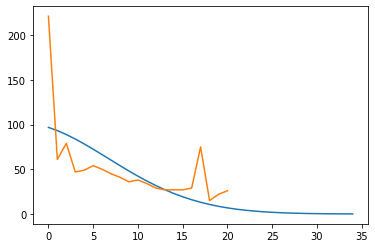

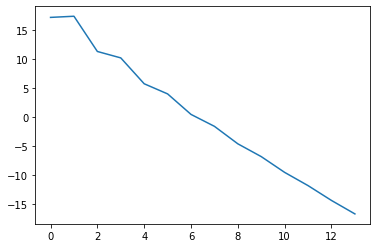

In [66]:
def train_arima(trainData, order=(2, 1, 0)):
    model = ARIMA(trainData, order=order)
    model_fit = model.fit(disp=0)

    return model_fit

preds = preds_map["36059"]
actual = util.get_deaths_list(36059, "2020-05-09")[-21:]

plt.plot(preds)
plt.plot(actual)

plt.show()

train_residuals = actual - preds[:21]
model = train_arima(train_residuals, order=(2, 1, 0))
forecast = model.forecast(steps=14)[0]

plt.plot(preds[-14:] + forecast)
